In [1]:
import numpy as np
from pyrex.main import *
from pyrex.core import *
import matplotlib.pyplot as plt
import lal
import lalsimulation as ls
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as
from pycbc.waveform import get_td_waveform

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
data_path = "/Users/yesety/Documents/AEI/projects/eccentric/catalog_ecc/"

name=[]
name.append(['SXS:BBH:0180','SXS:BBH:1355','SXS:BBH:1357','SXS:BBH:1358','SXS:BBH:1359','SXS:BBH:1360','SXS:BBH:1361','SXS:BBH:1362','SXS:BBH:1363'])
name.append(['SXS:BBH:0184','SXS:BBH:1364','SXS:BBH:1365','SXS:BBH:1366','SXS:BBH:1367','SXS:BBH:1368','SXS:BBH:1369'])
name.append(['SXS:BBH:0183','SXS:BBH:1372','SXS:BBH:1373','SXS:BBH:1374'])

e_comm=[]
e_comm.append([0,0.053,0.097,0.099,0.100,0.142,0.144,0.189,0.192])
e_comm.append([0,0.044,0.06,0.095,0.096,0.097,0.185])
e_comm.append([0,0.092,0.093,0.18]) #Hinder Phys Rev D 98 2018

l_comm=[]
l_comm.append([0.667,-2.788,1.371,-1.742,2.743,2.178,1.550,1.042,0.732])
l_comm.append([-0.604,2.144,1.938,1.013,-0.709,-1.963,-1.465])
l_comm.append([1.818,2.998,1.677,-0.265]) #Hinder Phys Rev D 98 201

q=[]
q.append(list(np.ones(len(e_comm[0]))+0))
q.append(list(np.ones(len(e_comm[1]))+1))
q.append(list(np.ones(len(e_comm[2]))+2))

data={}
data['name']=name[0]+name[1]+name[2]
data['e_comm']=e_comm[0]+e_comm[1]+e_comm[2]
data['q']=q[0]+q[1]+q[2]
data['l_comm']=l_comm[0]+l_comm[1]+l_comm[2]

In [3]:
data_training={}
data_training['name']=np.concatenate([data['name'][:3],data['name'][7:11],data['name'][14:17],data['name'][18:]])
data_training['e_comm']=np.concatenate([data['e_comm'][:3],data['e_comm'][7:11],data['e_comm'][14:17],data['e_comm'][18:]])
data_training['q']=np.concatenate([data['q'][:3],data['q'][7:11],data['q'][14:17],data['q'][18:]])
data_training['l_comm']=np.concatenate([data['l_comm'][:3],data['l_comm'][7:11],data['l_comm'][14:17],data['l_comm'][18:]])

data_test={}
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        data_test.setdefault('name', []).append(data['name'][i])
        data_test.setdefault('e_comm', []).append(data['e_comm'][i])
        data_test.setdefault('q', []).append(data['q'][i])
        data_test.setdefault('l_comm', []).append(data['l_comm'][i])

In [4]:
data_all = Glassware(q = data['q'], chi = 0, names = data['name'], e_ref = data['e_comm'])

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


In [5]:
training = Glassware(q = data_training['q'], chi = 0, names = data_training['name'], e_ref = data_training['e_comm'])

In [6]:
for i in range(len(data_all.names)):
    if data_all.names[i] not in training.names:
        data_test.setdefault('h22', []).append(data_all.h22[i])
        data_test.setdefault('time', []).append(data_all.time[i])

In [7]:
x_test=[]
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        x_test.append(data_all.x[i])
x_test

[np.float64(0.14139682985076596),
 np.float64(0.132758281522539),
 np.float64(0.11027495434452218),
 np.float64(0.11961646851279063),
 np.float64(0.12375690560387184),
 np.float64(0.14293288752385297),
 np.float64(0.13819894720860718),
 np.float64(0.12596736778632023)]

In [8]:
total_mass=50.

approximant1='IMRPhenomD'
approximant2='SEOBNRv4'
spin1x=0.
spin1y=0.
spin1z=0.
spin2x=0.
spin2y=0.
spin2z=0.

inclination=0.
distance=1.
coa_phase=0.

In [ ]:
_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm, out=None)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id

In [10]:
def resizeWave(time,strain,newtime,samplerate):  
    deltaT=1./samplerate
    newtime=np.arange(min(newtime),max(newtime),deltaT)
    inter_real=spline(time,np.real(strain))
    inter_im=spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime),delta_t=deltaT)
    time_im=TimeSeries(inter_im(newtime),delta_t=deltaT)
    return time_real,time_im

def compute_match(testtime,testh,timemodel,mdlh,newtm,samplerate):
    nrdt,nid=resizeWave(testtime,testh,newtm,samplerate)
    mdt,mdi=resizeWave(timemodel,mdlh,newtm,samplerate)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    cmatch=modify_match(nrdt,mdt,nid,mdi,psd=psd,low_frequency_cutoff=f_lower)
    return cmatch[0]

In [11]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    samplerate=4096
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    scale=NR_amp_scale(total_mass,distance)
    y22=find_Y22(inclination,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

0.099 1.0 0.9999999805407733 0.9999999939893444
0.1 1.0 0.9999999986431598 0.9999999997336129
0.142 1.0 0.9999999852827288 0.9999999850366892
0.144 1.0 0.9999999949735653 0.9999999906101855
0.06 2.0 0.9999999995913706 0.9999999999507523
0.095 2.0 0.9999999983560143 0.9999999988316564
0.096 2.0 0.9999999991321853 0.9999999997959196
0.092 3.0 0.9999999857557347 0.9999999981189026


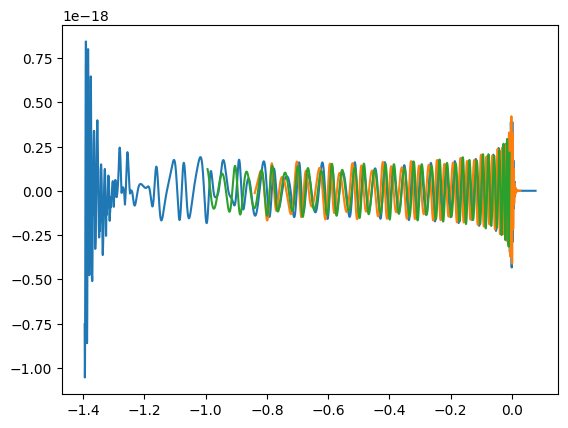

In [12]:
plt.plot(testPhenom.time[1700:],testPhenom.h22[1700:])
plt.plot(testSEOB.time[1700:],testSEOB.h22[1700:])
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22))
# plt.xlim(-0.5,0.1)
plt.show()

0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649
0.9999999941921649


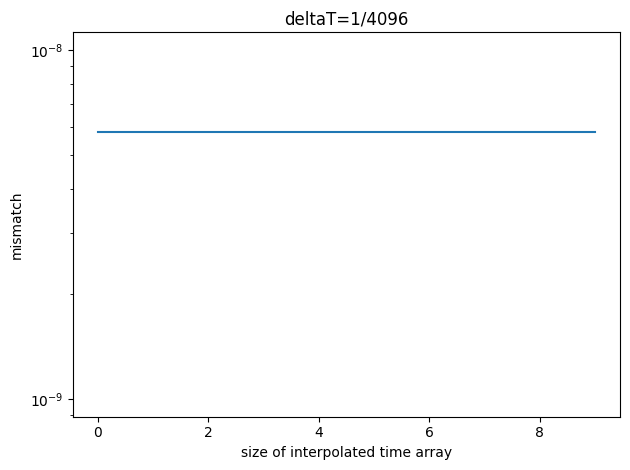

In [13]:
data_sizes = 10**np.linspace(2, 6, 10, dtype = np.int64)
matches = np.zeros_like(data_sizes, dtype = ndarray)
for ind, length in enumerate(data_sizes):
    newt = np.linspace(-1500, -50.4, length)
    matches[ind] = compute_match(testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,4096)
    print(matches[ind])
    
plt.semilogy(1-matches)
plt.ylabel('mismatch')
plt.title('deltaT=1/'+str(samplerate))
plt.xlabel('size of interpolated time array')
plt.tight_layout()

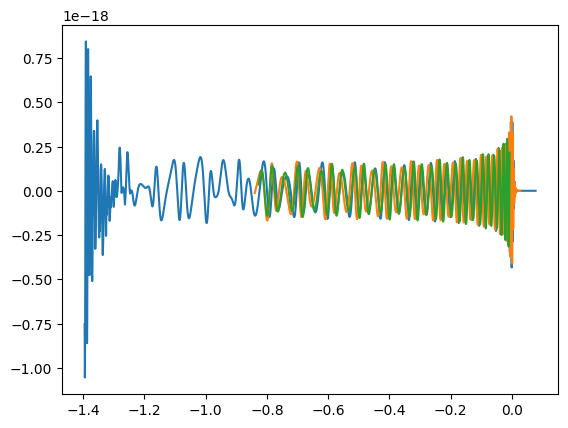

In [14]:
plt.plot(testPhenom.time[1700:],testPhenom.h22[1700:])
plt.plot(testSEOB.time[1700:],testSEOB.h22[1700:])
plt.plot(data_test['time'][i][1700:]*(total_mass*lal.MTSUN_SI),data_test['h22'][i][1700:]*(scale*y22))
# plt.xlim(-0.5,0.1)

In [15]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    samplerate = 4096
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time,testPhenom.h22,newt, samplerate)
    matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time,testSEOB.h22,newt, samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

0.099 1.0 nan 0.999999999999999
0.1 1.0 nan 0.9999999999999998
0.142 1.0 nan 0.9999999999999987
0.144 1.0 nan 1.0000000000000002
0.06 2.0 nan 0.9999999999999992
0.095 2.0 nan 0.9999999999999987
0.096 2.0 nan 1.0000000000000007
0.092 3.0 nan 1.0000000000000002


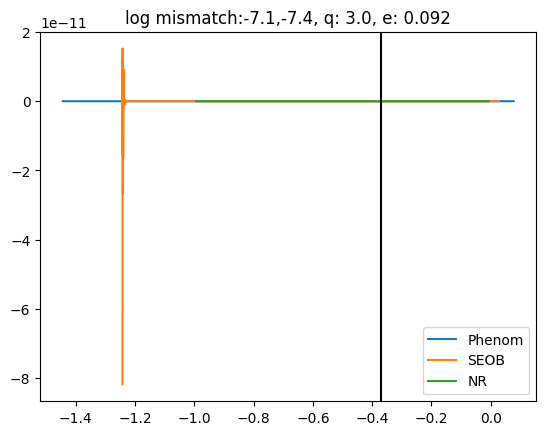

In [16]:
i=7    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-np.pi/2*1j),label='SEOB')
plt.plot(data_test['time'][7]*(total_mass*lal.MTSUN_SI),data_test['h22'][7]*(scale*y22)*np.exp(-np.pi/2*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')


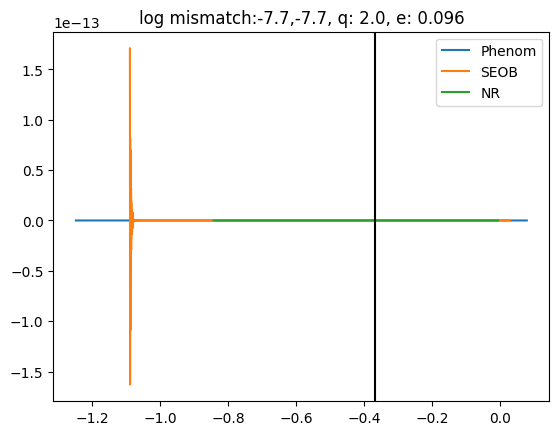

In [18]:
i=6    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
samplerate = 4096
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(3./5*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(np.pi/2*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

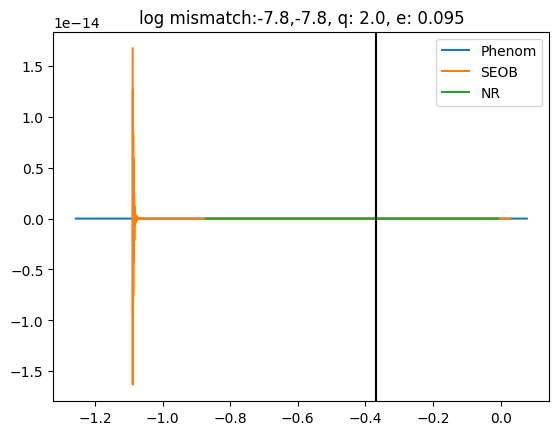

In [19]:
i=5    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(2./3*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-np.pi/2*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

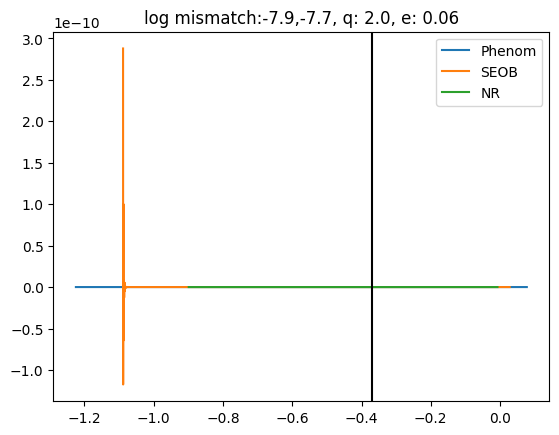

In [20]:
i=4   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-np.pi/3*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

(-0.443294185287714, 0.0024627454738206335)

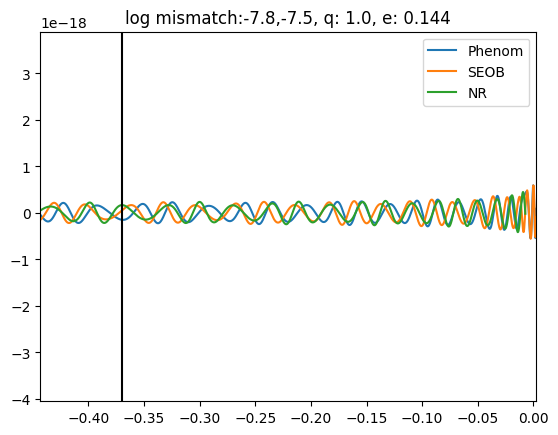

In [21]:
i=3   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(4./3*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(5./2*np.pi*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')
plt.xlim(-1800*(total_mass*lal.MTSUN_SI),10*(total_mass*lal.MTSUN_SI))

(-0.443294185287714, 0.0024627454738206335)

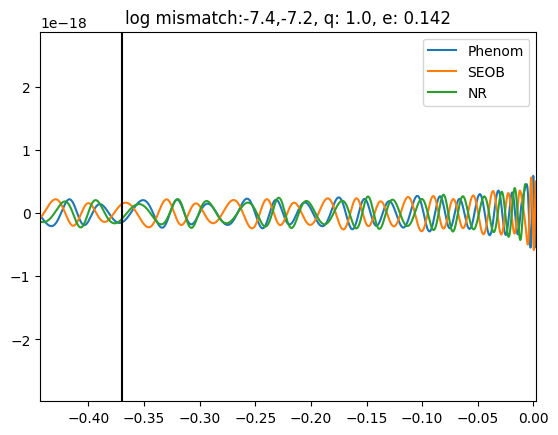

In [22]:
i=2   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-20j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')
plt.xlim(-1800*(total_mass*lal.MTSUN_SI),10*(total_mass*lal.MTSUN_SI))


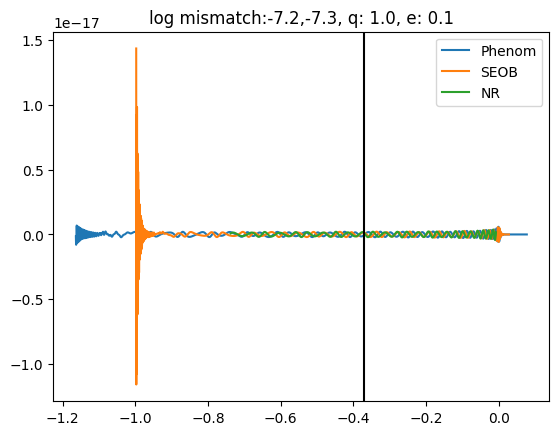

In [23]:
i=1   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(1./2*np.pi*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

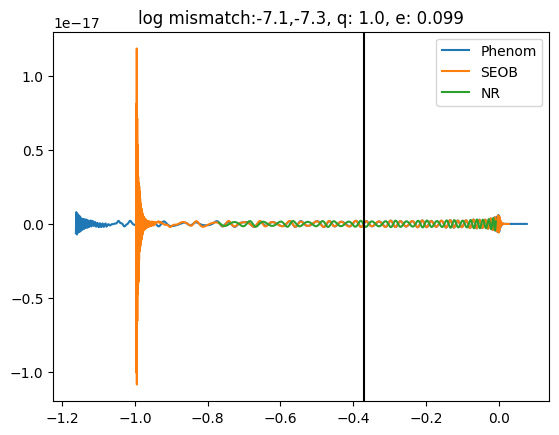

In [24]:
i=0   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-1./5*np.pi*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

In [25]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i]+1,total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]+0.6
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time,testPhenom.h22,newt,samplerate)
    matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time,testSEOB.h22,newt,samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(eccentricity,data_test['q'][i]+1,matchPhnm,matchSEOB)

(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.699 2.0 nan 1.0
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.7 2.0 nan 0.9999999999999993
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.742 2.0 nan 1.0
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.744 2.0 nan 0.9999999999999991
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.6599999999999999 3.0 nan 0.9999999999999988
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been c

In [26]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]+0.8
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testPhenom.time[1500:],testPhenom.h22[1500:],newt,samplerate)
    matchSEOB=compute_match(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22),testSEOB.time,testSEOB.h22,newt,samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(eccentricity,data_test['q'][i],matchPhnm,matchSEOB)

(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.899 1.0 0.9999999999999993 0.9999999999999991
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.9 1.0 0.9999999999999999 1.0000000000000004
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.9420000000000001 1.0 0.9999999999999996 1.0000000000000002
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.9440000000000001 1.0 0.9999999999999997 0.9999999999999999
(warning)>> This version has only been calibrated up to eccentricity<0.2.
(warning)>> This version has only been calibrated up to eccentricity<0.2.
0.8600000000000001 2.0 0.9999999999999992 0.

(6e-18, -6e-18)

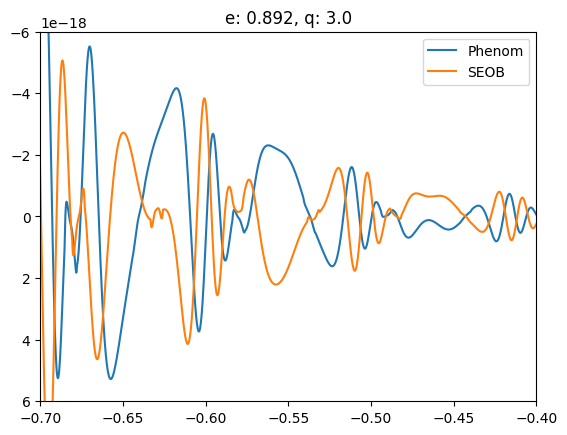

In [35]:
plt.plot(testPhenom.time[2200:],testPhenom.h22[2200:],label='Phenom')
plt.plot(testSEOB.time[2200:],testSEOB.h22[2200:],label='SEOB')
plt.title('e: '+str(eccentricity)+', q: '+str(data_test['q'][i]))
plt.legend()
plt.xlim(-.7,-.4)
plt.ylim(6e-18, -6e-18)

In [28]:
e_noncirc=np.concatenate((np.concatenate((data_all.e_ref[1:9],data_all.e_ref[10:16]),axis=0),data_all.e_ref[17:]),axis=0)
q_noncirc=np.concatenate((np.concatenate((data_all.q[1:9],data_all.q[10:16]),axis=0),data_all.q[17:]),axis=0)

A_omg_noncirc=np.concatenate((np.concatenate((data_all.A_omega[1:9],data_all.A_omega[10:16]),axis=0),data_all.A_omega[17:]),axis=0)
C_omg_noncirc=np.concatenate((np.concatenate((data_all.B_omega[1:9],data_all.B_omega[10:16]),axis=0),data_all.B_omega[17:]),axis=0)
fr_omg_noncirc=np.concatenate((np.concatenate((data_all.freq_omega[1:9],data_all.freq_omega[10:16]),axis=0),data_all.freq_omega[17:]),axis=0)
phi_omg_noncirc=np.concatenate((np.concatenate((data_all.phi_omega[1:9],data_all.phi_omega[10:16]),axis=0),data_all.phi_omega[17:]),axis=0)

In [29]:
e_noncirc=np.concatenate((np.concatenate((data_all.e_ref[1:9],data_all.e_ref[10:16]),axis=0),data_all.e_ref[17:]),axis=0)
q_noncirc=np.concatenate((np.concatenate((data_all.q[1:9],data_all.q[10:16]),axis=0),data_all.q[17:]),axis=0)

AA_noncirc=np.concatenate((np.concatenate((data_all.A_amp[1:9],data_all.A_amp[10:16]),axis=0),data_all.A_amp[17:]),axis=0)
CA_noncirc=np.concatenate((np.concatenate((data_all.B_amp[1:9],data_all.B_amp[10:16]),axis=0),data_all.B_amp[17:]),axis=0)
frA_noncirc=np.concatenate((np.concatenate((data_all.freq_amp[1:9],data_all.freq_amp[10:16]),axis=0),data_all.freq_amp[17:]),axis=0)
phiA_noncirc=np.concatenate((np.concatenate((data_all.phi_amp[1:9],data_all.phi_amp[10:16]),axis=0),data_all.phi_amp[17:]),axis=0)